<a href="https://colab.research.google.com/github/LuisAnibalVasquez/BankTransactionFraudDetector/blob/main/FraudDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook is part of my professional portfolio

The main goal is to develop a Deep Learning model that allows determining when a bank transaction is fraudulent.

To train the model, [The Kaggle Credit Card Transactions Fraud Detection Dataset](https://) was used. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
!gdown --id 1sQ94R105jgVRNC8wDBkQ6mcSDBkv2Kra
!gdown --id 1UN4R-IUNLqAKIN8-goUGT5drov9_e6zy


Downloading...
From: https://drive.google.com/uc?id=1sQ94R105jgVRNC8wDBkQ6mcSDBkv2Kra
To: /content/fraudTrain.csv
100% 351M/351M [00:04<00:00, 83.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UN4R-IUNLqAKIN8-goUGT5drov9_e6zy
To: /content/fraudTest.csv
100% 150M/150M [00:01<00:00, 108MB/s]


##EDA

Check the csv files and some basic information about the data

In [4]:
import pandas as pd

train_csv = pd.read_csv('fraudTrain.csv')
test_csv = pd.read_csv('fraudTest.csv')

train_csv.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
test_csv.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


##*Both dataset are unbalanced*

In [6]:
train_csv.shape

(1296675, 23)

In [7]:
train_csv.is_fraud.value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [8]:
test_csv.shape

(555719, 23)

In [9]:
test_csv.is_fraud.value_counts()

0    553574
1      2145
Name: is_fraud, dtype: int64

In [10]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

##Checking correlated features in the dataset

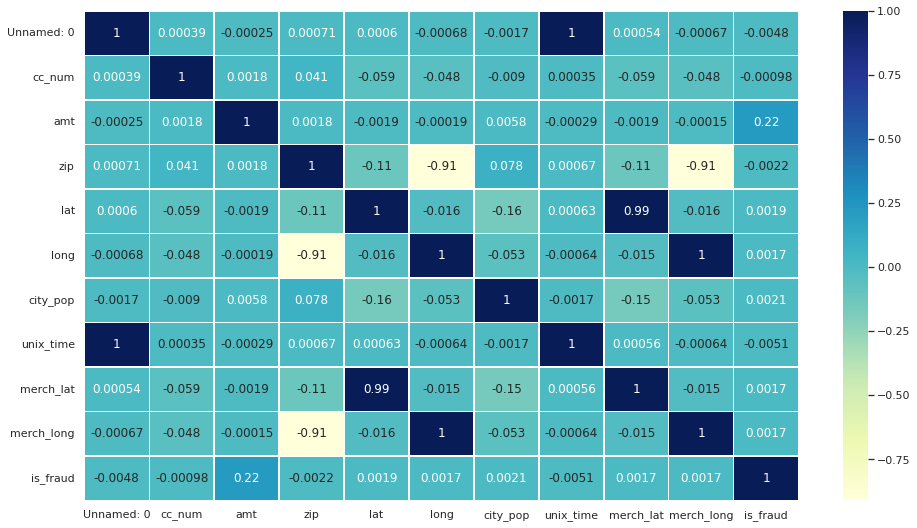

In [11]:
import seaborn as sns
correlations = train_csv.corr()
sns.set(rc = {'figure.figsize':(16,9)})
ax = sns.heatmap(correlations, linewidths=.5, cmap="YlGnBu",annot=True)

In [12]:
df_uncorrelated = train_csv.drop(columns=['Unnamed: 0','lat','long','merch_lat','merch_long', 'zip', 'unix_time'])
df_uncorrelated.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,city_pop,job,dob,trans_num,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,0


Drop any other string feature.

In [13]:
df_final = df_uncorrelated. drop(columns=['first','last','street','city_pop','job','dob','trans_num','trans_date_trans_time'])   
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   cc_num    1296675 non-null  int64  
 1   merchant  1296675 non-null  object 
 2   category  1296675 non-null  object 
 3   amt       1296675 non-null  float64
 4   gender    1296675 non-null  object 
 5   city      1296675 non-null  object 
 6   state     1296675 non-null  object 
 7   is_fraud  1296675 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 79.1+ MB


One-hot encoding for gender feature

In [14]:
gender_dummies = pd.get_dummies(df_final['gender'], drop_first = True)
gender_dummies = gender_dummies.rename(columns = {'M': 'Gender_encoded'}, inplace = False)
gender_dummies.head()

,Gender_encoded
0,0
1,0
2,1
3,1
4,1


In [15]:
df_final.insert(7, 'Gender_encoded', gender_dummies)
df_final.head()


,cc_num,merchant,category,amt,gender,city,state,Gender_encoded,is_fraud
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,0,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,1,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,1,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,1,0


In [16]:
df_final = df_final. drop(columns=['gender'])   

In [17]:
df_final.head()

,cc_num,merchant,category,amt,city,state,Gender_encoded,is_fraud
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,0,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Malad City,ID,1,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,1,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Doe Hill,VA,1,0


In [18]:
df_final.category.value_counts()

gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: category, dtype: int64

In [20]:
category_array = df_final.category.unique()

In [21]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[df_final.category.unique()])
encoder.fit(df_final[["category"]])

#df_final["category-encoded"] = encoder.transform(df_final[["category"]])


df_final.insert(7, 'category_encoded', encoder.transform(df_final[["category"]]))

df_final = df_final. drop(columns=['merchant','category','city','state'])   


df_final.head()

,cc_num,amt,Gender_encoded,category_encoded,is_fraud
0,2703186189652095,4.97,0,0.0,0
1,630423337322,107.23,0,1.0,0
2,38859492057661,220.11,1,2.0,0
3,3534093764340240,45.00,1,3.0,0
4,375534208663984,41.96,1,4.0,0
